In [47]:
import pyreadr
import numpy as np
import pandas as pd

DIAGNOSIS_MAPPING = {
    'AD': 'AD',
    'CN': 'NCI',
    'EMCI': 'MCI',
    'LMCI': 'MCI',
    'SMC': 'NCI'
}

df = pyreadr.read_r('/home/esten/Downloads/results/anonymized_analysis_set.rds')[None]
print(f'Found {len(df)} samples')
df['diagnosis'] = df['DX_bl'].apply(lambda x: DIAGNOSIS_MAPPING[x])
df['Age'] = df['BaselineAge']

Found 2303 samples


In [48]:
# Prepares dataset

import os
import numpy as np
import pandas as pd


NUM_FOLDS = 10

PROGRESSION_TARGET = 'progression'

PROGRESSION_CUTOFF = 5 # years
SAMPLE_CUTOFF = 90

MANUSCRIPT_DATA_FOLDER = os.path.join(os.pardir, 'manuscript', 'data')

def calculate_progression(update_status: int, update_timepoint: int, 
                          threshold: float = 365.25 * PROGRESSION_CUTOFF):
    if update_status == 1 and update_timepoint < threshold:
        return 1
    elif update_status == 0 or update_timepoint >= threshold:
        return 0
    
    return np.nan

df = df.dropna(subset=['Age']).copy()
df['Sex'] = df['Sex'].apply(lambda x: {'Female': 0, 'Male': 1}[x])
df['age_at_mri'] = df['Age'] + df['Time_to_MRI'] / 365.25
df['age_at_sample'] = df['Age'] + df['Time_to_Sample'] / 365.25
df['brainage_delta'] = df['brainage'] - df['age_at_mri']

df = df[(np.isnan(df['Time_to_Sample'])) | (np.abs(df['Time_to_Sample']) < SAMPLE_CUTOFF)]
df = df[(np.isnan(df['Time_to_MRI'])) | (np.abs(df['Time_to_MRI']) < SAMPLE_CUTOFF)]

df['progression'] = df[['Coxreg_update_status', 'Coxreg_update_time_conversion']].apply(
    lambda x: calculate_progression(x[0], x[1]), axis=1
)
df['CN/AD'] = df['diagnosis'].apply(
    lambda x: {'NCI': 0, 'AD': 1, 'MCI': np.nan}[x]
)
df['CN/MCI'] = df['diagnosis'].apply(
    lambda x: {'NCI': 0, 'AD': np.nan, 'MCI': 1,}[x]
)
df['MCI/AD'] = df['diagnosis'].apply(
    lambda x: {'NCI': np.nan, 'AD': 1, 'MCI': 0}[x]
)
    


/tmp/ipykernel_2538609/53349544.py:36: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [49]:
from collections import Counter


mrna = df[~pd.isna(df['Time_to_Sample'])]
print(f'Found {len(mrna)} samples with mrna')
mrna = mrna.sort_values(['diagnosis', 'progression', 'Sex', 'Age'])
mrna['fold'] = np.arange(len(mrna)) % 3
test = mrna[mrna['fold'] == 1]
train = mrna[mrna['fold'] != 1]
print(f'Reserved {len(test)} samples for testing')
remaining = df[pd.isna(df['Time_to_Sample'])]
full_train = pd.concat([train, remaining])
print(f'Training on {len(full_train)} samples ({len(train)} + {len(remaining)})')

datasets = {'train': full_train, 'test': test}

train = datasets['train']
test = datasets['test']
full = pd.concat([train, test])
print(f'Train: {len(train)}')
print(f'Train with DNAm: {len(train[~pd.isna(train['dunedin_pace'])])}')
print(f'Test: {len(test)}')
print(f'Full: {len(full)}')
print(f'Train diagnoses: {Counter(train.loc[~pd.isna(train["diagnosis"]), "diagnosis"])}')
print(f'Train progression: {Counter(train.loc[~pd.isna(train["progression"]), "progression"])}')
print(f'Test diagnoses: {Counter(test.loc[~pd.isna(test["diagnosis"]), "diagnosis"])}')
print(f'Test progression: {Counter(test.loc[~pd.isna(test["progression"]), "progression"])}')

Found 385 samples with mrna
Reserved 128 samples for testing
Training on 1748 samples (257 + 1491)
Train: 1748
Train with DNAm: 257
Test: 128
Full: 1876
Train diagnoses: Counter({'MCI': 763, 'NCI': 620, 'AD': 365})
Train progression: Counter({0.0: 670, 1.0: 190})
Test diagnoses: Counter({'MCI': 80, 'NCI': 38, 'AD': 10})
Test progression: Counter({0.0: 92, 1.0: 24})


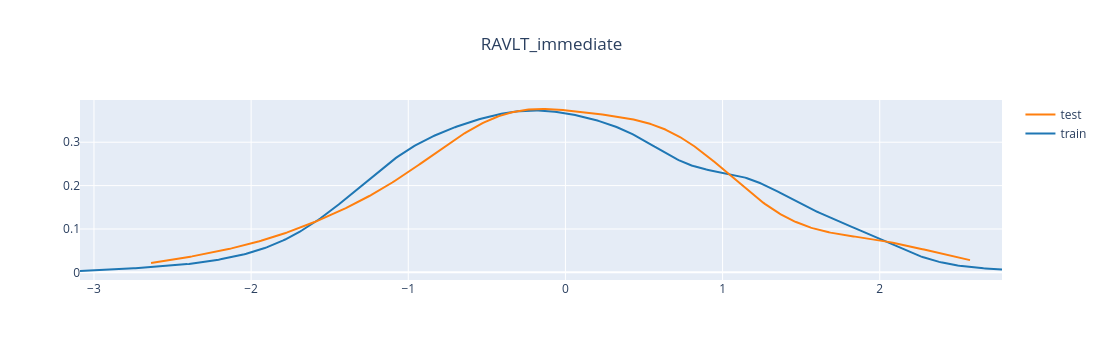

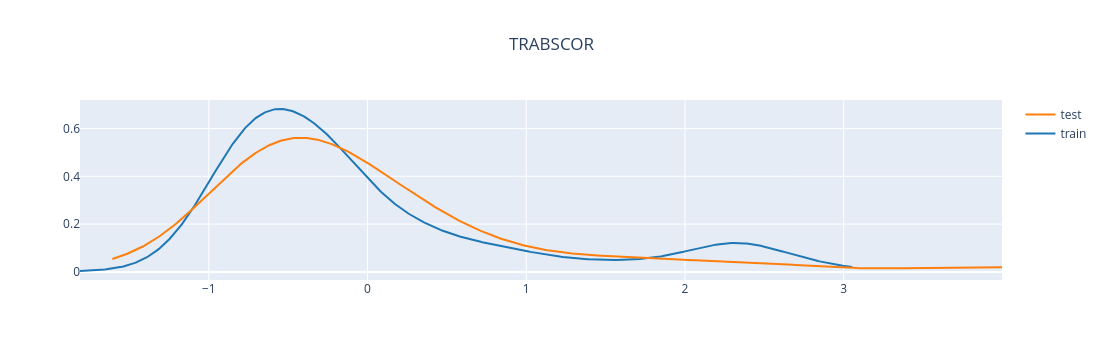

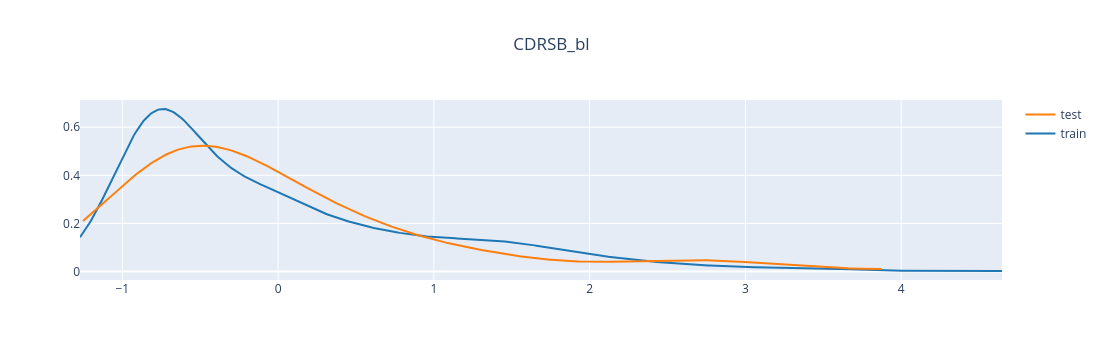

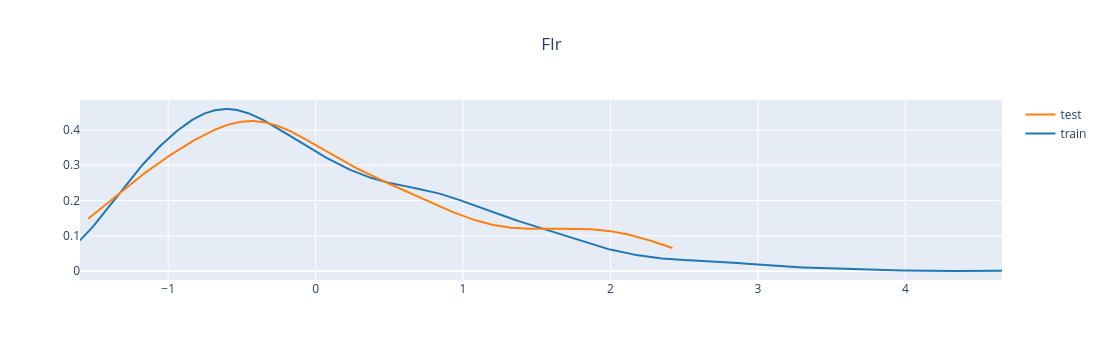

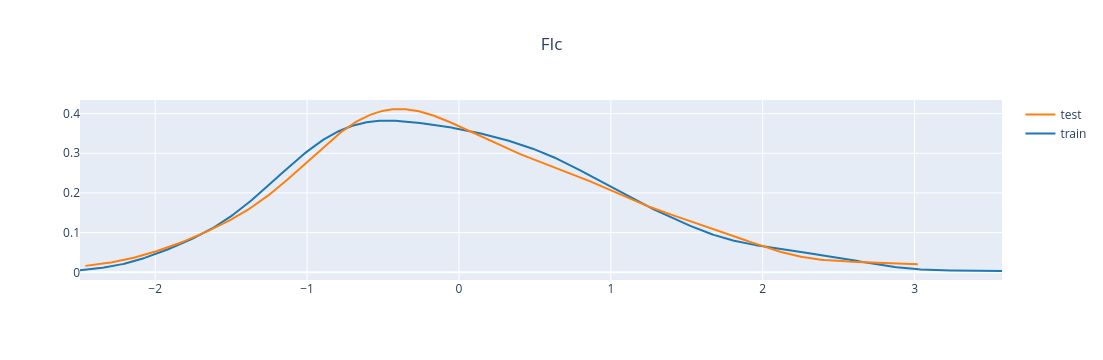

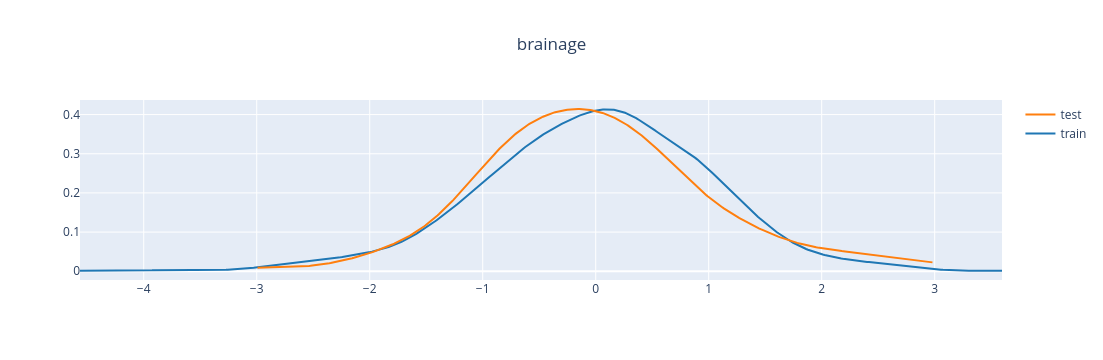

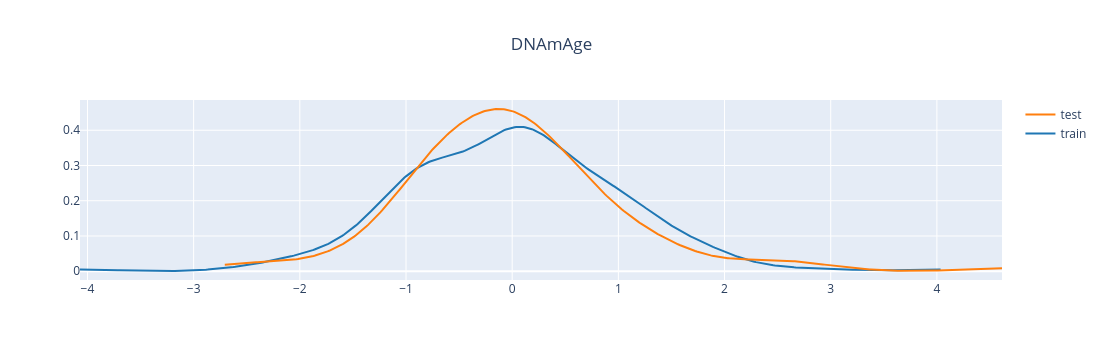

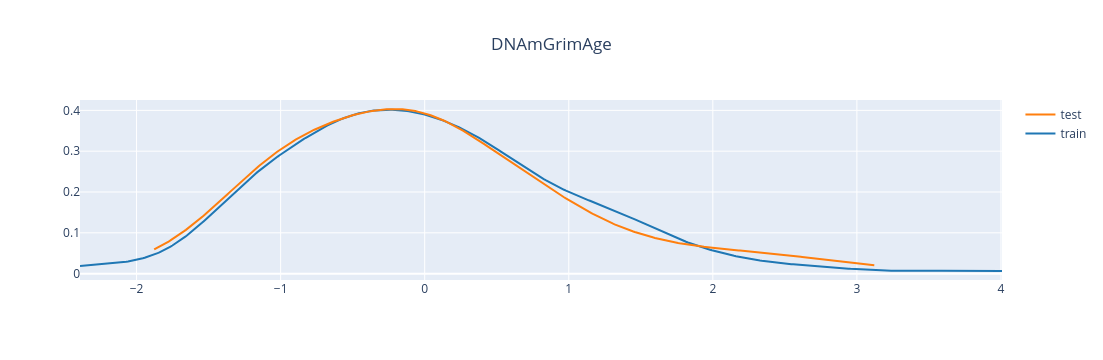

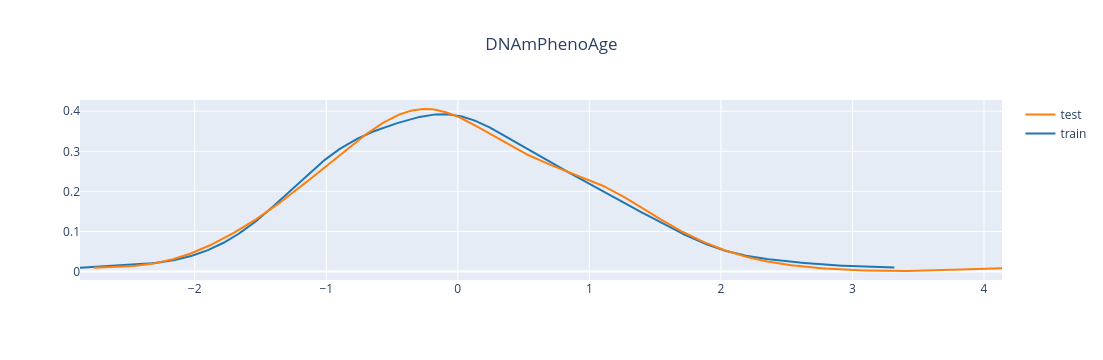

In [50]:
# z-score standardizes variables (with a linear model dependent on age)

from plotly.figure_factory import create_distplot
from sklearn.linear_model import LinearRegression
from typing import List


def correct(df: pd.DataFrame, column: str, age: str, others: List[pd.DataFrame] = None, 
            standardize: bool = False):
    if others is None:
        others = []
    
    df = df.copy()
    
    idx = (~pd.isna(df[column])) & (~pd.isna(df[age])) & (~pd.isna(df['Sex']))
    X = df.loc[idx, [age, 'Sex']].values
    y = df.loc[idx, column].values
    
    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)
    residuals = y - predictions
    
    if standardize:
        mean_value = np.mean(residuals)
        std_value = np.std(residuals)
        residuals = (residuals - mean_value) / std_value
    
    df[f'{column}_corrected'] = np.nan
    df.loc[idx, f'{column}_corrected'] = residuals
    
    for other_df in others:
        idx = ~pd.isna(other_df[column])
        
        if len(np.where(idx)[0]) == 0:
            print(f'Skipping {column}')
            continue
        
        X = other_df.loc[idx, [age, 'Sex']].values
        y = other_df.loc[idx, column].values
        predictions = model.predict(X)
        residuals = y - predictions
        
        if standardize:
            mean_value = np.mean(residuals)
            std_value = np.std(residuals)
            residuals = (residuals - mean_value) / std_value
    
        other_df[f'{column}_corrected'] = np.nan
        other_df.loc[idx, f'{column}_corrected'] = residuals
        
    
    return df, *others
    
variables_to_correct = [
    ('RAVLT_immediate', 'Age'),
    ('TRABSCOR', 'Age'),
    ('CDRSB_bl', 'Age'),
    ('FIr', 'Age'),
    ('FIc', 'Age'),
    ('brainage', 'age_at_mri'),
    ('DNAmAge', 'age_at_sample'),
    ('DNAmGrimAge', 'age_at_sample'),
    ('DNAmPhenoAge', 'age_at_sample'),
    ('DNAmAgeSkinBloodClock', 'age_at_sample'),
    ('DNAmGrimAge2BasedOnRealAge', 'age_at_sample'),
    ('dunedin_pace', 'age_at_sample'),
    ('pc_brain_age', 'age_at_sample'),
    ('DNAmGrimAge2BasedOnRealAge', 'age_at_sample')
]

for variable, age in variables_to_correct:
    train, test = correct(train, variable, age=age, others=[test], standardize=True)
    fig = create_distplot([train.loc[~pd.isna(train[f'{variable}_corrected']), f'{variable}_corrected'].values, 
                           test.loc[~pd.isna(test[f'{variable}_corrected']), f'{variable}_corrected'].values],
                          ['train', 'test'], show_hist=False, show_rug=False)
    fig.update_layout(title={'x': 0.5, 'text': variable})
    fig.show()

\scatterplot{DNAmAge_corrected}{RAVLT_immediate_corrected}{0.29}{0.06}{0.132}{0.375}{nonsigcolour}%0.710
\scatterplot{DNAmAge_corrected}{TRABSCOR_corrected}{0.23}{-0.06}{-0.172}{-0.373}{nonsigcolour}%0.710
\scatterplot{DNAmGrimAge_corrected}{RAVLT_immediate_corrected}{0.19}{-0.08}{0.132}{-0.467}{nonsigcolour}%0.710
\scatterplot{DNAmGrimAge_corrected}{TRABSCOR_corrected}{0.72}{0.02}{-0.172}{0.116}{nonsigcolour}%0.874
\scatterplot{DNAmPhenoAge_corrected}{RAVLT_immediate_corrected}{0.78}{-0.02}{0.132}{-0.099}{nonsigcolour}%0.874
\scatterplot{DNAmPhenoAge_corrected}{TRABSCOR_corrected}{0.87}{-0.01}{-0.173}{-0.050}{nonsigcolour}%0.874
\scatterplot{DNAmAgeSkinBloodClock_corrected}{RAVLT_immediate_corrected}{0.45}{0.05}{0.131}{0.272}{nonsigcolour}%0.710
\scatterplot{DNAmAgeSkinBloodClock_corrected}{TRABSCOR_corrected}{0.39}{-0.04}{-0.172}{-0.267}{nonsigcolour}%0.710
\scatterplot{dunedin_pace_corrected}{RAVLT_immediate_corrected}{0.01}{-0.15}{0.131}{-0.915}{sigcolour}%0.137
\scatterplot{dunedi

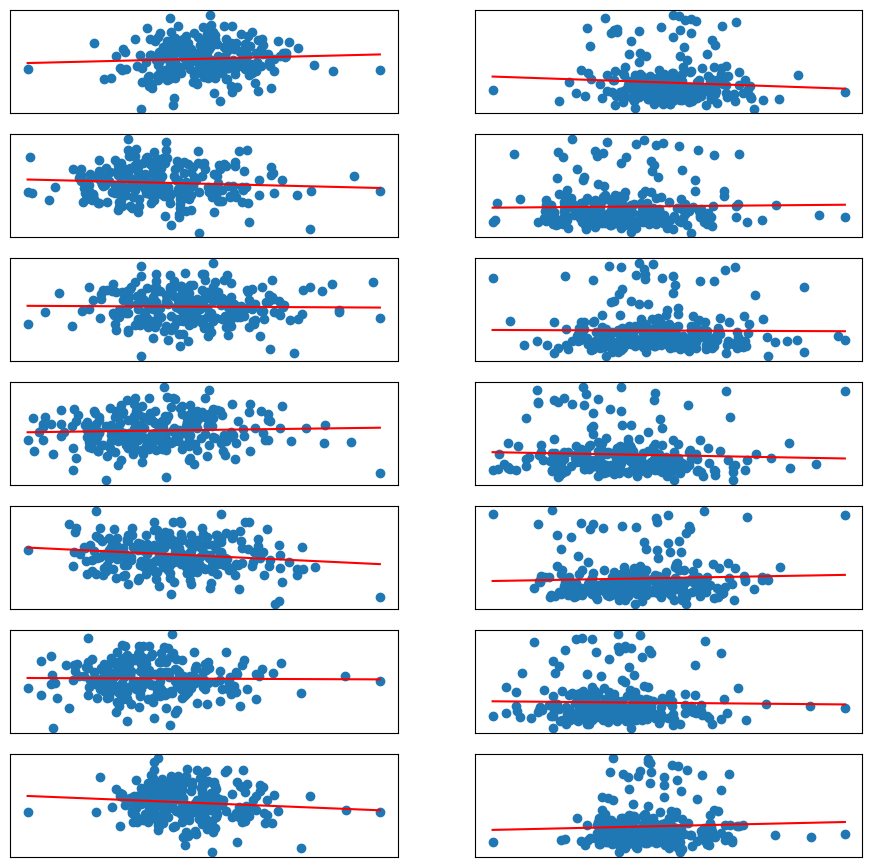

In [51]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import false_discovery_control
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection


model = LinearRegression()

targets = ['RAVLT_immediate', 'TRABSCOR']
predictors = ['DNAmAge', 'DNAmGrimAge', 'DNAmPhenoAge', 'DNAmAgeSkinBloodClock', 'dunedin_pace', 'pc_brain_age',
              'DNAmGrimAge2BasedOnRealAge']

ps = np.zeros((len(targets), len(predictors)))
coefs = np.zeros((len(targets), len(predictors)))
intercepts = np.zeros((len(targets), len(predictors)))

xmin=float('inf')
ymin=float('inf')
xmax=-float('inf')
ymax=-float('inf')

fig, ax = plt.subplots(len(predictors), len(targets), figsize=(11, 11))

for i, target in enumerate(targets):
    target = f'{target}_corrected'
    for j, predictor in enumerate(predictors):
        predictor = f'{predictor}_corrected'
        subset = train[(~pd.isna(train[target])) & (~pd.isna(train[predictor]))]
        
        scatter_df = pd.DataFrame({'X': subset[predictor], 'y': subset[target]})
        scatter_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'{predictor}_{target}_scatter.csv'),
                          index=False)
        
        model = sm.OLS(subset[target], sm.add_constant(subset[predictor]))
        summary = model.fit()
        ps[i,j] = summary.pvalues[predictor]
        coefs[i,j] = summary.params[predictor]
        intercepts[i,j] = summary.params['const']

        xmin=np.amin(subset[predictor])
        xmax=np.amax(subset[predictor])
        ymin=np.amin(subset[target])
        ymax=np.amin(subset[target])

        ax[j][i].scatter(subset[predictor], subset[target])
        ax[j][i].plot([xmin, xmax], [intercepts[i,j] + coefs[i,j] * xmin, intercepts[i,j] + coefs[i,j] * xmax], c='red')
        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])

adj = false_discovery_control(ps.flatten())
adj = np.reshape(adj, (len(targets), len(predictors)))

for j, predictor in enumerate(predictors):
    for i, target in enumerate(targets):
        colour = 'sigcolour' if ps[i,j] < 0.05 else 'nonsigcolour'
        print(f'\\scatterplot{{{predictor}_corrected}}{{{target}_corrected}}{{{ps[i,j]:.2f}}}{{{coefs[i,j]:.2f}}}'
              f'{{{intercepts[i,j]:.3f}}}{{{(6*coefs[i,j]):.3f}}}{{{colour}}}%{adj[i,j]:.3f}')

plt.show()

DP intercept: 0.01, coef:  0.84, R: 0.86
Grim intercept: 0.01, coef:  0.85, R: 0.87


/home/esten/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/home/esten/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



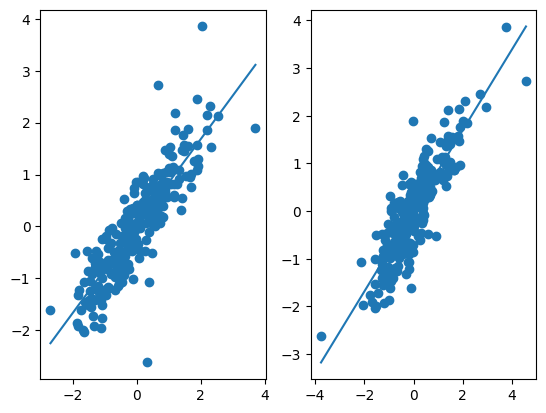

Train: 1748
Test: 128
Stage one: 1491
Stage two: 257


In [52]:
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

np.random.seed(42)

methylation_age_encoder = PCA(n_components=1)
methylation_age_idx = ~pd.isna(train['dunedin_pace_corrected']) & ~pd.isna(train['DNAmGrimAge2BasedOnRealAge_corrected'])
methylation_age_encoder.fit(train.loc[methylation_age_idx, ['dunedin_pace_corrected', 'DNAmGrimAge2BasedOnRealAge_corrected']].values)

train_aMA = methylation_age_encoder.transform(
    train.loc[methylation_age_idx, ['dunedin_pace_corrected', 'DNAmGrimAge2BasedOnRealAge_corrected']].values
).squeeze()

train_normal = np.sort(np.random.normal(0, 1, len(train_aMA)))
train_transformed = train_normal[np.argsort(np.argsort(train_aMA))]
train.loc[methylation_age_idx, 'aMA_corrected'] = train_transformed

test_aMA = methylation_age_encoder.transform(
    test[['dunedin_pace_corrected', 'DNAmGrimAge2BasedOnRealAge_corrected']].values
)
test_normal = np.sort(np.random.normal(0, 1, len(test_aMA)))
test_transformed = test_normal[np.argsort(np.argsort(test_aMA))]
test['aMA_corrected'] = test_transformed

stage_one = train[pd.isna(train['aMA_corrected'])]
stage_two = train[~pd.isna(train['aMA_corrected'])]

dp_model = LinearRegression()
dp_model.fit(stage_two[['dunedin_pace_corrected']], stage_two['aMA_corrected'])
dp_corr = np.corrcoef(stage_two['dunedin_pace_corrected'], stage_two['aMA_corrected'])[0,1]
print(f'DP intercept: {dp_model.intercept_:.2f}, coef: {dp_model.coef_[0]: .2f}, R: {dp_corr:.2f}')

grim_model = LinearRegression()
grim_model.fit(stage_two[['DNAmGrimAge2BasedOnRealAge_corrected']], stage_two['aMA_corrected'])
grim_corr = np.corrcoef(stage_two['DNAmGrimAge2BasedOnRealAge_corrected'], stage_two['aMA_corrected'])[0,1]
print(f'Grim intercept: {grim_model.intercept_:.2f}, coef: {grim_model.coef_[0]: .2f}, R: {grim_corr:.2f}')

fig, ax = plt.subplots(1, 2)
ax[0].scatter(stage_two['dunedin_pace_corrected'], stage_two['aMA_corrected'])
dp_X = np.asarray([np.amin(stage_two['dunedin_pace_corrected']), np.amax(stage_two['dunedin_pace_corrected'])])
dp_y = dp_model.predict(np.reshape(dp_X, (2, 1)))
ax[0].plot(dp_X, dp_y)

ax[1].scatter(stage_two['DNAmGrimAge2BasedOnRealAge_corrected'], stage_two['aMA_corrected'])
grim_X = np.asarray([np.amin(stage_two['DNAmGrimAge2BasedOnRealAge_corrected']), np.amax(stage_two['DNAmGrimAge2BasedOnRealAge_corrected'])])
grim_y = grim_model.predict(np.reshape(grim_X, (2, 1)))
ax[1].plot(grim_X, grim_y)
plt.show()

pca_df = pd.DataFrame({
    'aMA': stage_two['aMA_corrected'],
    'aDP': stage_two['dunedin_pace_corrected'],
    'aGrim': stage_two['DNAmGrimAge2BasedOnRealAge_corrected']
})
pca_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'pca.csv'.replace('/', '-')), index=False)

train.to_csv(os.path.join(os.pardir, 'data', 'train.csv'))
test.to_csv(os.path.join(os.pardir, 'data', 'test.csv'))
stage_one.to_csv(os.path.join(os.pardir, 'data', 'stage_one.csv'))
stage_two.to_csv(os.path.join(os.pardir, 'data', 'stage_two.csv'))
print(f'Train: {len(train)}')
print(f'Test: {len(test)}')
print(f'Stage one: {len(stage_one)}')
print(f'Stage two: {len(stage_two)}')

In [46]:
from scipy.stats import chi2_contingency, iqr, ranksums


continuous = ['Age', 'MMSE', 'RAVLT_immediate_corrected', 'TRABSCOR_corrected', 'aMA_corrected', 
              'dunedin_pace_corrected', 'DNAmGrimAge2BasedOnRealAge_corrected',
              'brainage_corrected', 'FIr_corrected']
categorical = ['Sex', 'APOE4']

dataset = train[(train['diagnosis'] == 'MCI') & (~pd.isna(train['aMA_corrected'])) & (~pd.isna(train['TRABSCOR_corrected']))]
pmci = dataset[dataset['progression'] == 1]
smci = dataset[dataset['progression'] == 0]
print(f'Len pMCI: {len(pmci)}')
print(f'Len sMCI: {len(smci)}')

for variable in continuous:
    print(variable)
    print(f'sMCI: {np.median(smci[variable]):.1f}, {np.percentile(smci[variable], 25):.1f}-{np.percentile(smci[variable], 75):.1f}')
    print(f'pMCI: {np.median(pmci[variable]):.1f}, {np.percentile(pmci[variable], 25):.1f}-{np.percentile(pmci[variable], 75):.1f}')
    p = np.round(ranksums(pmci[variable], smci[variable]).pvalue, 2)
    print(f'p: {p:3f}')

for variable in categorical:
    print(variable)
    smci_counter = Counter(smci[variable])
    pmci_counter = Counter(pmci[variable])
    print(f'sMCI: {smci_counter}')
    print(f'pMCI: {pmci_counter}')
    smci_counts = [smci_counter[key] for key in sorted(smci_counter.keys())]
    pmci_counts = [pmci_counter[key] for key in sorted(pmci_counter.keys())]
    print(smci_counts)
    print(pmci_counts)
    print(np.stack([smci_counts, pmci_counts]))
    p = chi2_contingency(np.array([smci_counts, pmci_counts])).pvalue
    print(f'p: {p}')

Len pMCI: 41
Len sMCI: 116
Age
sMCI: 70.5, 66.2-76.4
pMCI: 72.9, 68.3-76.1
p: 0.410000
MMSE
sMCI: 29.0, 28.0-29.0
pMCI: 27.0, 26.0-29.0
p: 0.000000
RAVLT_immediate_corrected
sMCI: 0.2, -0.4-0.7
pMCI: -0.5, -1.0--0.2
p: 0.000000
TRABSCOR_corrected
sMCI: -0.4, -0.7--0.0
pMCI: -0.1, -0.5-0.3
p: 0.030000
aMA_corrected
sMCI: -0.0, -0.7-0.5
pMCI: 0.3, -0.7-0.8
p: 0.230000
dunedin_pace_corrected
sMCI: -0.1, -0.5-0.5
pMCI: 0.3, -0.9-0.7
p: 0.550000
DNAmGrimAge2BasedOnRealAge_corrected
sMCI: -0.1, -0.7-0.4
pMCI: 0.1, -0.4-0.6
p: 0.090000
brainage_corrected
sMCI: -0.1, -0.8-0.6
pMCI: 0.2, -0.2-0.5
p: 0.150000
FIr_corrected
sMCI: -0.2, -0.7-0.2
pMCI: 0.3, -0.2-1.0
p: 0.000000
Sex
sMCI: Counter({1: 62, 0: 54})
pMCI: Counter({1: 24, 0: 17})
[54, 62]
[17, 24]
[[54 62]
 [17 24]]
p: 0.703825453164831
APOE4
sMCI: Counter({0.0: 73, 1.0: 33, 2.0: 10})
pMCI: Counter({1.0: 22, 0.0: 11, 2.0: 8})
[73, 33, 10]
[11, 22, 8]
[[73 33 10]
 [11 22  8]]
p: 0.00033386578068360644


Time_to_Sample: 1.00, 0.00-7.00


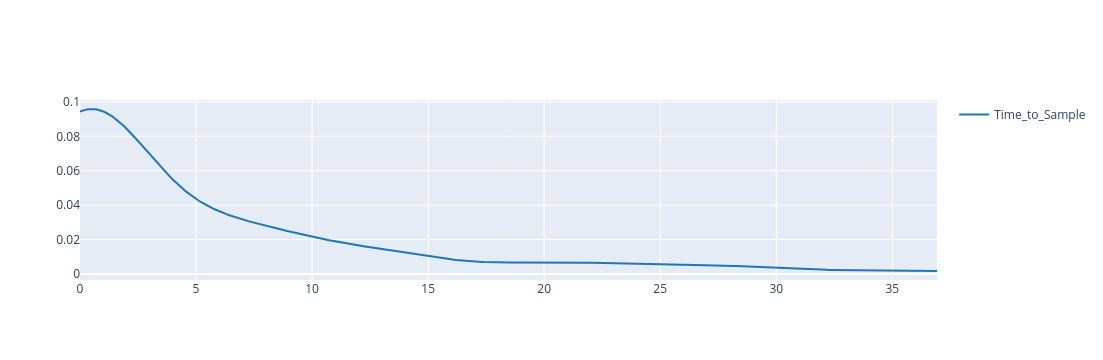

Time_to_MRI: 16.00, 9.00-27.00


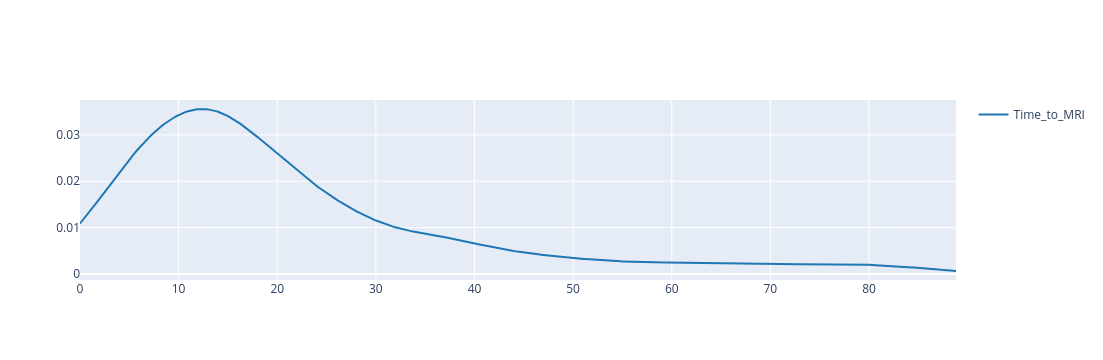

In [9]:
from plotly.figure_factory import create_distplot

for col in ['Time_to_Sample', 'Time_to_MRI']:
    idx = ~pd.isna(train[col])
    values = np.abs(train.loc[idx, col].values)
    print(f'{col}: {np.median(values):.2f}, '
          f'{np.percentile(values, 25):.2f}-{np.percentile(values, 75):.2f}')
    fig = create_distplot([values], [col], show_rug=False, show_hist=False)
    fig.show()

\traces{../../data/CN-AD_FIr.csv}{{,,}}{-1.06}{0.9}{0.89}{<0.001}
\traces{../../data/CN-AD_brainage.csv}{{,,}}{-0.2}{0.68}{0.48}{<0.001}
\traces{../../data/CN-AD_aMA.csv}{{,,}}{0.1}{0.5}{0.38}{=0.106}
\traces{../../data/CN-MCI_FIr.csv}{{,,}}{-1.06}{-0.5}{0.89}{<0.001}
\traces{../../data/CN-MCI_brainage.csv}{{,,}}{-0.2}{0.22}{0.48}{<0.001}
\traces{../../data/CN-MCI_aMA.csv}{{,,}}{0.1}{0.16}{0.4}{=0.396}
\traces{../../data/MCI-AD_FIr.csv}{{,,}}{-0.5}{0.9}{0.57}{<0.001}
\traces{../../data/MCI-AD_brainage.csv}{{,,}}{0.22}{0.68}{0.48}{<0.001}
\traces{../../data/MCI-AD_aMA.csv}{{,,}}{0.16}{0.5}{0.4}{=0.185}
\traces{../../data/progression_FIr.csv}{{,,}}{-0.72}{-0.42}{0.63}{<0.001}
\traces{../../data/progression_brainage.csv}{{,,}}{-0.1}{0.24}{0.47}{<0.001}
\traces{../../data/progression_aMA.csv}{{,,}}{0.08}{0.38}{0.41}{=0.115}


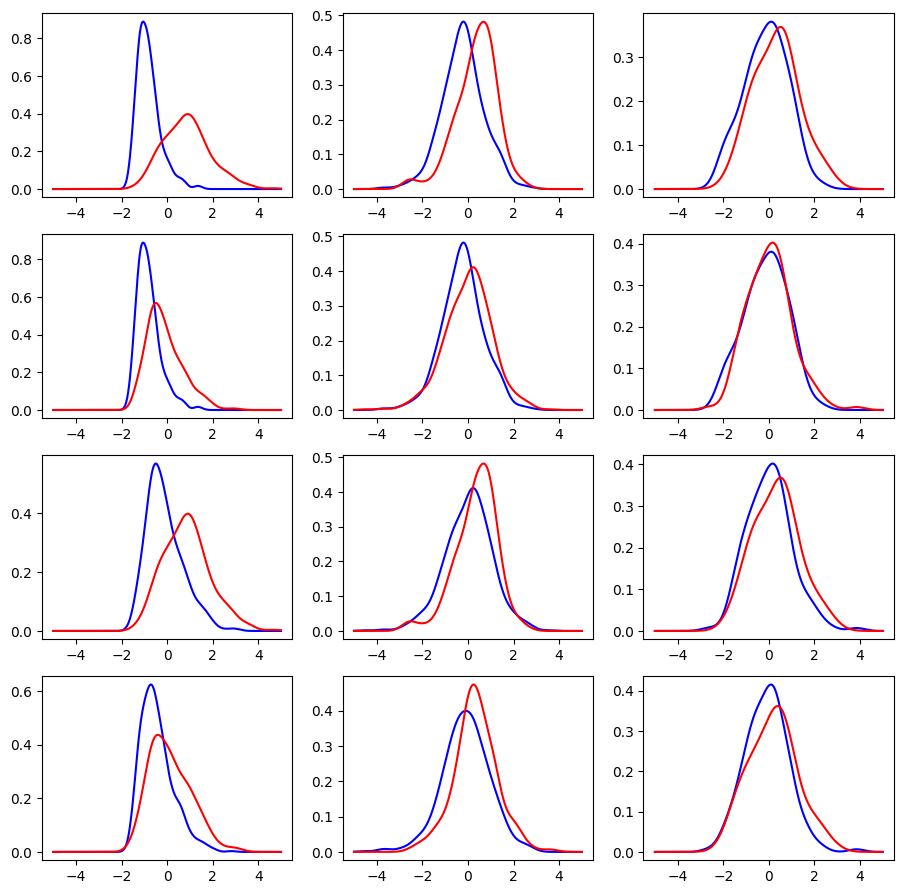

In [10]:
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde, kruskal, mode


targets = [
    ('CN/AD', ['CN', 'AD']),
    ('CN/MCI', ['CN', 'MCI']),
    ('MCI/AD', ['MCI', 'AD']),
    (PROGRESSION_TARGET, ['non-progressive', 'progressive']),
]
predictors = ['FIr', 'brainage', 'aMA']

ps = {}

for target, names in targets:
    for name in predictors:
        column = f'{name}_corrected'
        negative = train.loc[(train[target] == 0) & (~np.isnan(train[column])), column]
        positive = train.loc[(train[target] == 1) & (~np.isnan(train[column])), column]
        
        p = kruskal(negative, positive)[1]
        ps[f'{target}_{name}'] = p

keys = list(ps.keys())
p_values = [ps[key] for key in keys]
_, adj = fdrcorrection(p_values)
ps = {keys[i]: adj[i] for i in range(len(keys))}

fig, ax = plt.subplots(len(targets), len(predictors), figsize=(11, 11))

for i, (target, names) in enumerate(targets):
    for j, name in enumerate(predictors):
        column = f'{name}_corrected'
        xmin = np.nanmin(train[column])
        xmax = np.nanmax(train[column])
        negative = train.loc[(train[target] == 0) & (~np.isnan(train[column])), column]
        negative_kde = gaussian_kde(negative)
        positive = train.loc[(train[target] == 1) & (~np.isnan(train[column])), column]
        positive_kde = gaussian_kde(positive)
        
        x = np.linspace(-5, 5, 500)
        negative_ys = negative_kde(x)
        positive_ys = positive_kde(x)
        
        negative_median_x = np.argmax(negative_ys) / 50 - 5
        negative_median_y = np.amax(negative_ys)
        positive_median_x = np.argmax(positive_ys) / 50 - 5
        positive_median_y = np.amax(positive_ys)
        
        p = ps[f'{target}_{name}']
        p = '<0.001' if p < 0.001 else f'={np.round(p, 3)}'
        #if p > 0.01:
        #    p = f'{p: .2f}'
        #else:
        #    p = f'{p:.2E}'

        print(f'\\traces{{../../data/{target.replace("/", "-")}_{name}.csv}}'
              f'{{{{,,}}}}'
              f'{{{np.round(negative_median_x, 2)}}}'
              f'{{{np.round(positive_median_x, 2)}}}'
              f'{{{np.round(max(negative_median_y, positive_median_y), 2)}}}'
              f'{{{p}}}')
        #print(f'{target}, {column}: ({negative_mean_x:.2f}, {negative_mean_y:.2f}) vs '
        #      f'({positive_mean_x:.2f}, {positive_mean_y:.2f}), '
        #      f'p={p}')
        #traces.append(f'\\trace{../../data/{}{{{{,,}}}}'
        output = pd.DataFrame({'x': x, 'negative': negative_ys, 'positive': positive_ys})
        output.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER,
                                   f'{target}_{name}.csv'.replace('/', '-')), index=False)
        ax[i,j].plot(x, negative_ys, c='blue')
        ax[i,j].plot(x, positive_ys, c='red')
    
#plt.show()

In [11]:
from scipy.stats import spearmanr


to_correlate = ['RAVLT_immediate', 'TRABSCOR', 'APOE4', 'FIr', 'brainage', 'aMA']
names = ['aRAVLT', 'aTMT-B', 'APOE4', 'aFI', 'aBA', 'aMA']

correlations = np.zeros((len(to_correlate), len(to_correlate)))
correlation_df = stage_two

def determine_colour(value: float):
    if value > 0:
        return f'red!{int(value*100)}'

    return f'blue!{-int(value*100)}'

def print_correlation_traces(df: pd.DataFrame):
    values = df.values
    
    print(f'\\corrnode{{{round(values[1,0], 2)}}}{{{determine_colour(values[1,0])}}}{{n10}}{{(0,0)}}{{north}}')

    for i in range(2, len(values)):
        for j in range(i):
            location = f'n{i-1}{j}.south' if i - 1 != j else f'n{i}{j-1}.east'
            anchor = 'north' if i - 1 != j else 'west'
            colour = determine_colour(values[i, j])
            print(f'\\corrnode{{{round(values[i,j], 2)}}}{{{colour}}}{{n{i}{j}}}{{({location})}}{{{anchor}}}')

    print()
    
    for i in range(1, len(names)):
        print(f'\\node[anchor=east] at (n{i}0.west) {{{names[i]}}};')

    print()

    for i in range(len(names) - 1):
        print(f'\\node[anchor=east, rotate=45] at ($ (n{len(names)-1}{i}.south) - (0, 0.1) $) {{{names[i]}}};')

for i in range(len(to_correlate)):
    for j in range(0, i):
        if i == j:
            continue
            
        v1 = to_correlate[i] if to_correlate[i].startswith('APOE') else f'{to_correlate[i]}_corrected' 
        v2 = to_correlate[j] if to_correlate[j].startswith('APOE') else f'{to_correlate[j]}_corrected'
            
        idx = (~pd.isna(correlation_df[v1])) & (~pd.isna(correlation_df[v2]))
        if v1.startswith('APOE') or v2.startswith('APOE'):
            correlation = spearmanr(correlation_df.loc[idx, v2], correlation_df.loc[idx, v1])[0]
        else:
            correlation = np.corrcoef(correlation_df.loc[idx, v1], correlation_df.loc[idx, v2])[0, 1]
        
        correlations[i,j] = correlation
correlations = pd.DataFrame(correlations, index=names, columns=names)
print(f'=== COMBINED ===')
print_correlation_traces(correlations)

for label, sex in [('female', 0), ('male', 1)]:
    correlations = np.zeros((len(to_correlate), len(to_correlate)))
    for i in range(len(to_correlate)):
        for j in range(0, i):
            if i == j:
                continue

            v1 = to_correlate[i] if to_correlate[i].startswith('APOE') else f'{to_correlate[i]}_corrected' 
            v2 = to_correlate[j] if to_correlate[j].startswith('APOE') else f'{to_correlate[j]}_corrected'

            idx = (~pd.isna(correlation_df[v1])) & (~pd.isna(correlation_df[v2])) & \
                  (correlation_df['Sex'] == sex)
            if v1.startswith('APOE') or v2.startswith('APOE'):
                correlation = spearmanr(correlation_df.loc[idx, v2], correlation_df.loc[idx, v1])[0]
            else:
                correlation = np.corrcoef(correlation_df.loc[idx, v1], correlation_df.loc[idx, v2])[0, 1]

            correlations[i,j] = correlation
    
    correlations = pd.DataFrame(correlations, index=names, columns=names)
    print(f'=== {label.upper()} ===')
    print_correlation_traces(correlations)

=== COMBINED ===
\corrnode{-0.43}{blue!42}{n10}{(0,0)}{north}
\corrnode{-0.27}{blue!26}{n20}{(n10.south)}{north}
\corrnode{0.19}{red!18}{n21}{(n20.east)}{west}
\corrnode{-0.38}{blue!37}{n30}{(n20.south)}{north}
\corrnode{0.38}{red!38}{n31}{(n21.south)}{north}
\corrnode{0.21}{red!20}{n32}{(n31.east)}{west}
\corrnode{-0.19}{blue!18}{n40}{(n30.south)}{north}
\corrnode{0.1}{red!9}{n41}{(n31.south)}{north}
\corrnode{0.08}{red!8}{n42}{(n32.south)}{north}
\corrnode{-0.0}{blue!0}{n43}{(n42.east)}{west}
\corrnode{-0.15}{blue!15}{n50}{(n40.south)}{north}
\corrnode{0.06}{red!5}{n51}{(n41.south)}{north}
\corrnode{-0.0}{blue!0}{n52}{(n42.south)}{north}
\corrnode{0.2}{red!20}{n53}{(n43.south)}{north}
\corrnode{0.09}{red!8}{n54}{(n53.east)}{west}

\node[anchor=east] at (n10.west) {aTMT-B};
\node[anchor=east] at (n20.west) {APOE4};
\node[anchor=east] at (n30.west) {aFI};
\node[anchor=east] at (n40.west) {aBA};
\node[anchor=east] at (n50.west) {aMA};

\node[anchor=east, rotate=45] at ($ (n50.south) - (

In [10]:
# Find the best stage 1 models

from functools import reduce

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from warnings import simplefilter


simplefilter("ignore", category=ConvergenceWarning)

first_covariate_sets = {
    'baseline': ['Sex', 'Age'],
    'frailty': ['Sex', 'Age', 'FIr_corrected'],
    'brainage': ['Sex', 'Age', 'brainage_corrected'],
    'both': ['Sex', 'Age', 'FIr_corrected', 'brainage_corrected'],
    'clinical': ['Sex', 'Age', 'RAVLT_immediate_corrected', 'TRABSCOR_corrected', 'APOE4'],
    'clinical+both': ['Sex', 'Age', 'RAVLT_immediate_corrected', 'TRABSCOR_corrected', 'APOE4', 
                      'FIr_corrected', 'brainage_corrected']
}

def get_cv_aucs(pipeline, X, y, splitter):
    C = pipeline.steps[2][1].C_[0]
    aucs = []

    for train_idx, test_idx in splitter.split():
        model = LogisticRegression(C=C)
        model.fit(X.values[train_idx], y.values[train_idx])
        preds = model.predict_proba(X.values[test_idx])[:,1]
        auc = roc_auc_score(y.values[test_idx], preds)
        aucs.append(auc)

    return np.round(np.asarray(aucs), 2)

def get_predictions(pipeline, X, y, splitter):
    C = pipeline.steps[2][1].C_[0]
    predictions = None
    ys = None

    for train_idx, test_idx in splitter.split():
        model = LogisticRegression(C=C)
        model.fit(X.values[train_idx], y.values[train_idx])
        fold_predictions = model.predict_proba(X.values[test_idx])[:,1]
        predictions = fold_predictions if predictions is None else np.concatenate([predictions, fold_predictions])
        ys = y.values[test_idx] if ys is None else np.concatenate([ys, y.values[test_idx]])

    return predictions, ys
    

def fit_model(df: pd.DataFrame, predictors: List[str], target: str):
    df = df.copy()
    df = df.dropna(subset=predictors + [target])

    df = df.sort_values([target, 'Sex', 'Age'])
    df['fold'] = np.arange(len(df)) % NUM_FOLDS
    splitter = PredefinedSplit(df['fold'])

    X = df[predictors]
    y = df[target]

    model = LogisticRegressionCV(scoring='roc_auc', random_state=42, cv=splitter, class_weight='balanced',
                                 penalty='l1', solver='liblinear', n_jobs=8)
    pipeline = make_pipeline(
        StandardScaler(),
        SimpleImputer(),
        model
    )
    pipeline.fit(X, y)

    cv_aucs = get_cv_aucs(pipeline, X, y, splitter)
    coef = {predictors[i]: np.round(model.coef_[0][i], 5) for i in range(len(predictors))}
    
    predictions = pipeline.predict_proba(X)[:,1]
    train_auc = roc_auc_score(y, predictions)

    predictions, ys = get_predictions(pipeline, X, y, splitter)
    
    return {
        'train': train_auc,
        'cv': cv_aucs,
        'coef': coef,
        'pipeline': pipeline,
        'predictions': predictions, 
        'ys': ys
    }

first_results = {}
first_winners = {}

for target in ['CN/AD', 'CN/MCI', 'MCI/AD', 'progression']:
    first_results[target] = {}
    for name, covariates in first_covariate_sets.items():
        first_results[target][name] = fit_model(stage_one, covariates, target)
        cv_aucs = first_results[target][name]['cv']
        training_auc = first_results[target][name]['train']
        print(f'{target}/{name}: {np.mean(cv_aucs):.2} ({training_auc:.2f})')

    keys = np.asarray(['baseline', 'brainage', 'frailty', 'both'])
    mean_aucs = [np.round(np.mean(first_results[target][key]['cv']), 2) for key in keys]
    best = keys[np.argmax(mean_aucs)]

    print(f'{best}: {first_results[target][best]["coef"]}')
    first_winners[target] = best

CN/AD/baseline: 0.66 (0.65)
CN/AD/frailty: 0.95 (0.94)
CN/AD/brainage: 0.73 (0.73)
CN/AD/both: 0.94 (0.94)
CN/AD/clinical: 0.98 (0.98)
CN/AD/clinical+both: 0.99 (0.99)
frailty: {'Sex': 0.0, 'Age': 0.0, 'FIr_corrected': 1.94037}
CN/MCI/baseline: 0.62 (0.62)
CN/MCI/frailty: 0.79 (0.79)
CN/MCI/brainage: 0.63 (0.63)
CN/MCI/both: 0.79 (0.79)
CN/MCI/clinical: 0.82 (0.83)
CN/MCI/clinical+both: 0.86 (0.87)
frailty: {'Sex': 0.28446, 'Age': -0.18817, 'FIr_corrected': 1.32336}
MCI/AD/baseline: 0.58 (0.58)
MCI/AD/frailty: 0.79 (0.80)
MCI/AD/brainage: 0.62 (0.62)
MCI/AD/both: 0.8 (0.79)
MCI/AD/clinical: 0.83 (0.84)
MCI/AD/clinical+both: 0.86 (0.87)
both: {'Sex': -0.14325, 'Age': 0.30806, 'FIr_corrected': 1.16923, 'brainage_corrected': 0.15726}
progression/baseline: 0.62 (0.62)
progression/frailty: 0.72 (0.71)
progression/brainage: 0.67 (0.67)
progression/both: 0.74 (0.75)
progression/clinical: 0.89 (0.89)
progression/clinical+both: 0.91 (0.91)
both: {'Sex': -0.09023, 'Age': 0.42412, 'FIr_corrected'

In [11]:
import warnings
import statsmodels.api as sm

from itertools import chain, combinations
from sklearn.base import BaseEstimator

warnings.simplefilter('ignore', category=UserWarning)

dna_m_ages = ['aMA_corrected']
predictors = [list(combination) for i in range(len(dna_m_ages)) for combination in combinations(dna_m_ages, i+1)]

second_results = {}
second_winners = {}
second_without = {}
clinical_results = {}

for target in ['CN/AD', 'CN/MCI', 'MCI/AD', 'progression']:
    stage_1_winners = first_covariate_sets[first_winners[target]]
    
    baseline = fit_model(stage_two, predictors=['Age', 'Sex'], target=target)
    s1_model = first_results[target]['baseline']['pipeline']
    s1 = fit_model(stage_two, predictors=stage_1_winners, target=target)
    
    print(f'{target}/baseline: {np.mean(baseline["cv"]):.2f}')
    print(f'{target}/s1: {np.mean(s1["cv"]):.2f}')
    
    second_results[target] = {'baseline': baseline, 's1': s1}

    outcome = fit_model(stage_two, predictors=['Age', 'Sex', 'aMA_corrected'], target=target)
    second_results[target]['aMA'] = outcome
    print(f'{target}/aMA: {np.mean(outcome["cv"]):.2f}')
    outcome = fit_model(stage_two, predictors=stage_1_winners + ['aMA_corrected'], target=target)
    print(f'{target}/aMA+: {np.mean(outcome["cv"]):.2f}')
    second_results[target]['aMA+'] = outcome
            
    keys = np.asarray(['baseline', 's1', 'aMA', 'aMA+'])
    mean_aucs = [np.round(np.mean(second_results[target][key]['cv']), 2) for key in keys]
    best = keys[np.argmax(mean_aucs)]
    second_winners[target] = best
    print(best)

    keys_without = np.asarray(['baseline', 's1', 'aMA'])
    mean_aucs_without = [np.round(np.mean(second_results[target][key]['cv']), 2) for key in keys_without]
    best_without = keys_without[np.argmin(mean_aucs_without)]
    second_without[target] = best_without

CN/AD/baseline: 0.59
CN/AD/s1: 0.98
CN/AD/aMA: 0.62
CN/AD/aMA+: 0.96
s1
CN/MCI/baseline: 0.62
CN/MCI/s1: 0.81
CN/MCI/aMA: 0.62
CN/MCI/aMA+: 0.81
s1
MCI/AD/baseline: 0.68
MCI/AD/s1: 0.83
MCI/AD/aMA: 0.65
MCI/AD/aMA+: 0.82
s1
progression/baseline: 0.58
progression/s1: 0.77
progression/aMA: 0.57
progression/aMA+: 0.77
s1


In [14]:
from sklearn.metrics import roc_curve


targets = ['CN/AD', 'CN/MCI', 'MCI/AD']

for target in targets:
    cv_df = pd.DataFrame({
        'x': np.random.normal(0, 0.05, NUM_FOLDS),
        'bl': np.random.permutation(first_results[target]['baseline']['cv']),
        'brainage': np.random.permutation(first_results[target]['brainage']['cv']),
        'frailty': np.random.permutation(first_results[target]['frailty']['cv']),
        'both': np.random.permutation(first_results[target]['both']['cv']),
        'bl2': np.random.permutation(second_results[target]['baseline']['cv']),
        'dnam': np.random.permutation(second_results[target][second_without[target]]['cv']),
        's1': np.random.permutation(second_results[target]['s1']['cv']),
        'dnam+': np.random.permutation(second_results[target][second_winners[target]]['cv']),
        'clinical': np.random.permutation(first_results[target]['clinical']['cv']),
        'clinical+both': np.random.permutation(first_results[target]['clinical+both']['cv']),
    })

    cv_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'{target.replace("/", "_")}_cv.df'), index=False)
        
    print()
    
    print('    \\pgfplotsforeachungrouped \\colname/\\idx in {bl/0, brainage/1, frailty/2, both/3} {')
    print(f'        \\cvtrace{{../../data/{target.replace("/", "_")}_cv.df}}{{\\colname}}{{\\idx}}')
    print('    }')

    print()

    means = [np.round(np.mean(cv_df[col]), 2) for col in ['bl2', 'dnam', 's1', 'dnam+']]
    
    for i, value in enumerate(means):
        print(f'    \\meantrace{{{i}}}{{{value}}}{{black}}{{0}}')

    print()

    test_subset = test[~pd.isna(t    cv_df = pd.DataFrame({
        'x': np.random.normal(0, 0.05, NUM_FOLDS),
        'bl': np.random.permutation(first_results[target]['baseline']['cv']),
        'brainage': np.random.permutation(first_results[target]['brainage']['cv']),
        'frailty': np.random.permutation(first_results[target]['frailty']['cv']),
        'both': np.random.permutation(first_results[target]['both']['cv']),
        'bl2': np.random.permutation(second_results[target]['baseline']['cv']),
        'dnam': np.random.permutation(second_results[target][second_without[target]]['cv']),
        's1': np.random.permutation(second_results[target]['s1']['cv']),
        'dnam+': np.random.permutation(second_results[target][second_winners[target]]['cv']),
        'clinical': np.random.permutation(first_results[target]['clinical']['cv']),
        'clinical+both': np.random.permutation(first_results[target]['clinical+both']['cv']),
    })
est[target])]
    
    first_covariates = list(first_results[target][first_winners[target]]['coef'].keys())
    first_X = test_subset[first_covariates]
    first_predictions = first_results[target][first_winners[target]]['pipeline'].predict_proba(first_X)[:, 1]
    first_auc = roc_auc_score(test_subset[target], first_predictions)
    
    second_covariates = list(second_results[target][second_winners[target]]['coef'].keys())
    second_X = test_subset[second_covariates]
    second_predictions = second_results[target][second_winners[target]]['pipeline'].predict_proba(second_X)[:, 1]
    second_auc = roc_auc_score(test_subset[target], second_predictions)
    if first_winners[target] == 'both':
        print(f'    \\meantrace{{3}}{{{first_auc:.2f}}}{{red}}{{0}}')
    else:
        print(f'    \\meantrace{{2}}{{{first_auc:.2f}}}{{red}}{{0}}')

    print()    
    
    for key in ['baseline', 'brainage', 'frailty', 'both']:
        fpr, tpr, _ = roc_curve(first_results[target][key]["ys"], first_results[target][key]["predictions"])
        cv_roc_df = pd.DataFrame({
            'fpr': fpr,
            'tpr': tpr
        })
        cv_roc_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'{key}_{target.replace("/", "-")}_roc.csv'))
        #print(f'{key}: {roc_auc_score(first_results[target][key]["ys"], first_results[target][key]["predictions"]):.2f}')abs

    print()



    \pgfplotsforeachungrouped \colname/\idx in {bl/0, brainage/1, frailty/2, both/3} {
        \cvtrace{../../data/CN_AD_cv.df}{\colname}{\idx}
    }

    \meantrace{0}{0.59}{black}{0}
    \meantrace{1}{0.59}{black}{0}
    \meantrace{2}{0.98}{black}{0}
    \meantrace{3}{0.98}{black}{0}

    \meantrace{2}{0.94}{red}{0}



    \pgfplotsforeachungrouped \colname/\idx in {bl/0, brainage/1, frailty/2, both/3} {
        \cvtrace{../../data/CN_MCI_cv.df}{\colname}{\idx}
    }

    \meantrace{0}{0.62}{black}{0}
    \meantrace{1}{0.62}{black}{0}
    \meantrace{2}{0.81}{black}{0}
    \meantrace{3}{0.81}{black}{0}

    \meantrace{2}{0.75}{red}{0}



    \pgfplotsforeachungrouped \colname/\idx in {bl/0, brainage/1, frailty/2, both/3} {
        \cvtrace{../../data/MCI_AD_cv.df}{\colname}{\idx}
    }

    \meantrace{0}{0.68}{black}{0}
    \meantrace{1}{0.65}{black}{0}
    \meantrace{2}{0.83}{black}{0}
    \meantrace{3}{0.83}{black}{0}

    \meantrace{3}{0.84}{red}{0}




In [18]:
from sklearn.metrics import roc_curve


targets = ['CN/AD', 'CN/MCI', 'MCI/AD', 'progression']

for target in targets:
    cv_df = pd.DataFrame({
        'x': np.random.normal(0, 0.05, NUM_FOLDS),
        'bl': np.random.permutation(first_results[target]['baseline']['cv']),
        'brainage': np.random.permutation(first_results[target]['brainage']['cv']),
        'frailty': np.random.permutation(first_results[target]['frailty']['cv']),
        'both': np.random.permutation(first_results[target]['both']['cv']),
        'bl2': np.random.permutation(second_results[target]['baseline']['cv']),
        'dnam': np.random.permutation(second_results[target][second_without[target]]['cv']),
        's1': np.random.permutation(second_results[target]['s1']['cv']),
        'dnam+': np.random.permutation(second_results[target][second_winners[target]]['cv']),
        'clinical': np.random.permutation(first_results[target]['clinical']['cv']),
        'clinical+both': np.random.permutation(first_results[target]['clinical+both']['cv']),
    })

    print()
    
    print('    \\pgfplotsforeachungrouped \\colname/\\idx in {bl2/0, dnam/1, s1/2, dnam+/3} {')
    print(f'        \\cvtrace{{../../data/{target.replace("/", "_")}_cv.df}}{{\\colname}}{{\\idx}}')
    print('    }')

    print()

    means = [np.round(np.mean(cv_df[col]), 2) for col in ['bl2', 'dnam', 's1', 'dnam+']]
    
    for i, value in enumerate(means):
        print(f'    \\meantrace{{{i}}}{{{value}}}{{black}}{{0}}')

    print()

    test_subset = test[~pd.isna(test[target])]

    second_covariates = list(second_results[target][second_winners[target]]['coef'].keys())
    second_X = test_subset[second_covariates]
    second_predictions = second_results[target][second_winners[target]]['pipeline'].predict_proba(second_X)[:, 1]
    second_auc = roc_auc_score(test_subset[target], second_predictions)
    if second_winners[target] == 'dnam+':
        print(f'    \\meantrace{{3}}{{{second_auc:.2f}}}{{red}}{{0}}')
    else:
        print(f'    \\meantrace{{2}}{{{second_auc:.2f}}}{{red}}{{0}}')

    print()    
    
    for key in ['baseline', 'aMA', 's1', 'aMA+']:
        fpr, tpr, _ = roc_curve(second_results[target][key]["ys"], second_results[target][key]["predictions"])
        cv_roc_df = pd.DataFrame({
            'fpr': fpr,
            'tpr': tpr
        })
        cv_roc_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'{key}_{target.replace("/", "-")}_second_roc.csv'))
        #print(f'{key}: {roc_auc_score(first_results[target][key]["ys"], first_results[target][key]["predictions"]):.2f}')abs




    \pgfplotsforeachungrouped \colname/\idx in {bl2/0, dnam/1, s1/2, dnam+/3} {
        \cvtrace{../../data/CN_AD_cv.df}{\colname}{\idx}
    }

    \meantrace{0}{0.59}{black}{0}
    \meantrace{1}{0.59}{black}{0}
    \meantrace{2}{0.98}{black}{0}
    \meantrace{3}{0.98}{black}{0}

    \meantrace{2}{0.95}{red}{0}


    \pgfplotsforeachungrouped \colname/\idx in {bl2/0, dnam/1, s1/2, dnam+/3} {
        \cvtrace{../../data/CN_MCI_cv.df}{\colname}{\idx}
    }

    \meantrace{0}{0.62}{black}{0}
    \meantrace{1}{0.62}{black}{0}
    \meantrace{2}{0.81}{black}{0}
    \meantrace{3}{0.81}{black}{0}

    \meantrace{2}{0.75}{red}{0}


    \pgfplotsforeachungrouped \colname/\idx in {bl2/0, dnam/1, s1/2, dnam+/3} {
        \cvtrace{../../data/MCI_AD_cv.df}{\colname}{\idx}
    }

    \meantrace{0}{0.68}{black}{0}
    \meantrace{1}{0.65}{black}{0}
    \meantrace{2}{0.83}{black}{0}
    \meantrace{3}{0.83}{black}{0}

    \meantrace{2}{0.86}{red}{0}


    \pgfplotsforeachungrouped \colname/\idx in {bl2/

In [15]:
from sklearn.metrics import roc_curve

target = 'progression'

cv_df = pd.DataFrame({
    'x': np.random.normal(0, 0.05, NUM_FOLDS),
    'bl': np.random.permutation(first_results[target]['baseline']['cv']),
    'brainage': np.random.permutation(first_results[target]['brainage']['cv']),
    'frailty': np.random.permutation(first_results[target]['frailty']['cv']),
    'both': np.random.permutation(first_results[target]['both']['cv']),
    'bl2': np.random.permutation(second_results[target]['baseline']['cv']),
    'dnam': np.random.permutation(second_results[target][second_without[target]]['cv']),
    's1': np.random.permutation(second_results[target]['s1']['cv']),
    'dnam+': np.random.permutation(second_results[target][second_winners[target]]['cv']),
    'clinical': np.random.permutation(first_results[target]['clinical']['cv']),
    'clinical+both': np.random.permutation(first_results[target]['clinical+both']['cv']),
})

cv_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'{target.replace("/", "_")}_cv.df'), index=False)\

print('\\pgfplotsforeachungrouped \\colname/\\idx in {bl/0, brainage/1, frailty/2, both/3} {')
print(f'    \\cvtrace{{../../data/{target.replace("/", "_")}_cv.df}}{{\\colname}}{{\\idx}}')
print('}')

print()

means = [np.round(np.mean(cv_df[col]), 2) for col in ['bl', 'brainage', 'frailty', 'both']]

for i, value in enumerate(means):
    print(f'\\meantrace{{{i}}}{{{value}}}{{black}}{{0}}')

print()

test_subset = test[~pd.isna(test[target])]

first_covariates = list(first_results[target][first_winners[target]]['coef'].keys())
first_X = test_subset[first_covariates]
first_predictions = first_results[target][first_winners[target]]['pipeline'].predict_proba(first_X)[:, 1]
first_auc = roc_auc_score(test_subset[target], first_predictions)

second_covariates = list(second_results[target][second_winners[target]]['coef'].keys())
second_X = test_subset[second_covariates]
second_predictions = second_results[target][second_winners[target]]['pipeline'].predict_proba(second_X)[:, 1]
second_auc = roc_auc_score(test_subset[target], second_predictions)

for key in ['baseline', 'brainage', 'frailty', 'both']:
    fpr, tpr, _ = roc_curve(first_results["progression"][key]["ys"], first_results["progression"][key]["predictions"])
    cv_roc_df = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr
    })
    cv_roc_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'{key}_progression_roc.csv'))
    print(f'{key}: {roc_auc_score(first_results["progression"][key]["ys"], first_results["progression"][key]["predictions"]):.2f}')

\pgfplotsforeachungrouped \colname/\idx in {bl/0, brainage/1, frailty/2, both/3} {
    \cvtrace{../../data/progression_cv.df}{\colname}{\idx}
}

\meantrace{0}{0.62}{black}{0}
\meantrace{1}{0.67}{black}{0}
\meantrace{2}{0.72}{black}{0}
\meantrace{3}{0.74}{black}{0}

260
baseline: 0.62
249
brainage: 0.67
260
frailty: 0.71
249
both: 0.74


\cvtrace{../../data/progression_cv.csv}{aging}{0}
\meantrace{0}{0.74}{black}{0}
\cvtrace{../../data/progression_cv.csv}{clinical}{1}
\meantrace{1}{0.89}{black}{0}
\cvtrace{../../data/progression_cv.csv}{all}{2}
\meantrace{2}{0.91}{black}{0}
\meantrace{2}{0.83}{red}{0}



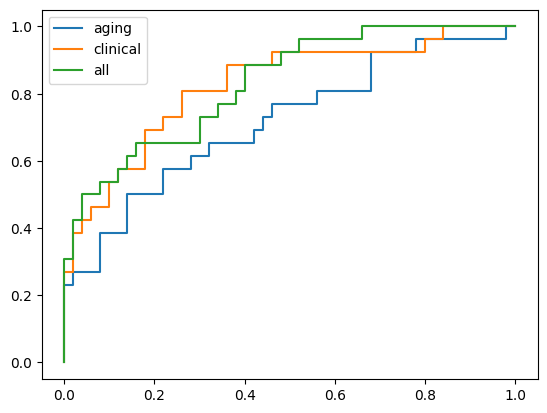

In [18]:
from sklearn.metrics import roc_curve


predictors = {
    'aging': ['Sex', 'Age', 'FIr_corrected', 'brainage_corrected'],
    'clinical': ['Sex', 'Age', 'RAVLT_immediate_corrected', 'TRABSCOR_corrected', 'APOE4']
}
predictors['all'] = list(set(predictors['aging'] + predictors['clinical']))

test_subset = test[~pd.isna(test['progression'])]

cv_df = pd.DataFrame({
    'x': np.random.normal(0, 0.05, NUM_FOLDS)
})

final_models = {}

for i, name in enumerate(['aging', 'clinical', 'all']):
    outcome = fit_model(stage_one, predictors=predictors[name], target=target)
    cv_df[name] = outcome['cv']
    test_predictions = outcome['pipeline'].predict_proba(test_subset[predictors[name]])[:,1]
    test_auc = roc_auc_score(test_subset['progression'], test_predictions)

    final_models[name] = {
        'pipeline': outcome['pipeline'],
        'predictions': test_predictions,
        'coef': outcome['coef']
    }
    
    print(f'\\cvtrace{{../../data/progression_cv.csv}}{{{name}}}{{{i}}}')
    print(f'\\meantrace{{{i}}}{{{np.round(np.mean(outcome["cv"]), 2)}}}{{black}}{{0}}')

    if name == 'all':
        print(f'\\meantrace{{{i}}}{{{np.round(np.mean(test_auc), 2)}}}{{red}}{{0}}')

cv_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, 'progression_cv.csv'), index=False)

print()

for name in ['aging', 'clinical', 'all']:
    predictions = test_predictions
    fpr, tpr, _ = roc_curve(test_subset['progression'], final_models[name]['predictions'])
    roc_df = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
    })
    roc_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'{name}_roc.csv'), index=False)

    plt.plot(roc_df['fpr'], roc_df['tpr'], label=name)

plt.legend()
plt.show()

1491
Counter({1.0: 139, 0.0: 121, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1

In [72]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, recall_score, roc_curve, \
                            precision_score

final_train = stage_one[predictors['all'] + ['progression']]
final_train = final_train.dropna()
train_X = final_train[predictors['all']]

train_predictions = final_models['all']['pipeline'].predict_proba(train_X)[:, 1]
fpr, tpr, thresholds = roc_curve(final_train['progression'].values, 
                                 train_predictions)
gmeans = np.sqrt(tpr * (1-fpr))
threshold = thresholds[np.argmax(gmeans)]
print(f'Threshold: {threshold}')
test_predictions = final_models['all']['predictions']
rounded_predictions = np.where(test_predictions > threshold, 1, 0)

female_idx = test_subset['Sex'] == 0
female_y = test_subset['progression'].values[female_idx]
female_yhat = test_predictions[female_idx]
male_y = test_subset['progression'].values[~female_idx]
male_yhat = test_predictions[~female_idx]
female_auc = roc_auc_score(female_y, female_yhat)
print(f'Female AUC: {female_auc}')
male_auc = roc_auc_score(male_y, male_yhat)
print(f'Male AUC: {male_auc}')

cm = confusion_matrix(test_subset['progression'], rounded_predictions)
acc = balanced_accuracy_score(test_subset['progression'], rounded_predictions)
sensitivity = recall_score(test_subset['progression'], rounded_predictions)
specificity = recall_score(test_subset['progression'], rounded_predictions, pos_label=0)
ppv = precision_score(test_subset['progression'], rounded_predictions)

coefs = {key: np.round(final_models["all"]["coef"][key], 2) for key in final_models["all"]["coef"]}
coefs = [(key, value) for key, value in coefs.items()]
coefs = sorted(coefs, key=lambda x: np.abs(x[1]))[::-1]

print(f'{cm[0,0]}&{cm[0,1]}\\\\')
print('\\hline')
print(f'{cm[1,0]}&{cm[1,1]}\\\\')
print(f'Balanced accuracy: {acc * 100:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Positive predictive value: {ppv:.2f}')
print(f'Coef: {coefs}')

name_mapping = {
    'RAVLT_immediate_corrected': 'aRAVLT', 
    'FIr_corrected': 'aFI', 
    'Sex': 'Sex', 
    'brainage_corrected': 'aBA', 
    'TRABSCOR_corrected': 'aTRABSCOR', 
    'Age': 'Age', 
    'APOE4': 'APOE4', 
    'DNAmGrimAge2BasedOnRealAge': 'aGrimAge2', 
    'dunedin_pace_corrected': 'aDunedinPACE'
}

Threshold: 0.5162242994442938
Female AUC: 0.7747035573122529
Male AUC: 0.8691358024691358
42&8\\
\hline
9&17\\
Balanced accuracy: 74.69
Sensitivity: 0.65
Specificity: 0.84
Positive predictive value: 0.68
Coef: [('RAVLT_immediate_corrected', -1.51), ('Age', 1.01), ('TRABSCOR_corrected', 0.72), ('FIr_corrected', 0.67), ('APOE4', 0.61), ('brainage_corrected', 0.44), ('Sex', -0.08)]
\begin{tabular}{|c|c|c|c|c|c|c|}
    \hline
    aRAVLT&Sex&aBA&APOE4&aFI&aTRABSCOR&Age\\
    \hline
    0.44&1.01&0.67&0.61&-1.51&0.72&-0.08\\
    \hline
\end{tabular}


In [65]:
fic_first_covariate_sets = {
    'baseline': ['Sex', 'Age'],
    'frailty': ['Sex', 'Age', 'FIc_corrected'],
    'brainage': ['Sex', 'Age', 'brainage_corrected'],
    'both': ['Sex', 'Age', 'FIc_corrected', 'brainage_corrected'],
    'clinical': ['Sex', 'Age', 'RAVLT_immediate_corrected', 'TRABSCOR_corrected', 'APOE4'],
    'clinical+both': ['Sex', 'Age', 'RAVLT_immediate_corrected', 'TRABSCOR_corrected', 'APOE4', 
                      'FIc_corrected', 'brainage_corrected']
}

fic_first_results = {}
fic_first_winners = {}

for target in ['CN/AD', 'CN/MCI', 'MCI/AD', 'progression']:
    fic_first_results[target] = {}
    for name, covariates in fic_first_covariate_sets.items():
        fic_first_results[target][name] = fit_model(stage_one, covariates, target)
        cv_aucs = fic_first_results[target][name]['cv']
        training_auc = fic_first_results[target][name]['train']
        print(f'{target}/{name}: {np.mean(cv_aucs):.2f} ({training_auc:.2f})')
    
    best = reduce(
        lambda x, y: x if np.mean(fic_first_results[target][x]['cv']) > np.mean(fic_first_results[target][y]['cv']) else y, 
        [modelname for modelname in fic_first_results[target].keys() if 'clinical' not in modelname]
    )
    print(f'{best}: {fic_first_results[target][best]["coef"]} ({fic_first_results[target][best]["cv"].mean():.2f})')
    fic_first_winners[target] = best

dna_m_ages = ['aMA_corrected']
predictors = [list(combination) for i in range(len(dna_m_ages)) for combination in combinations(dna_m_ages, i+1)]

fic_second_results = {}
fic_second_winners = {}

for target in ['CN/AD', 'CN/MCI', 'MCI/AD', 'progression']:
    stage_1_winners = fic_first_covariate_sets[first_winners[target]]
    
    baseline = fit_model(stage_two, predictors=['Age', 'Sex'], target=target)
    s1_model = fic_first_results[target]['baseline']['pipeline']
    s1 = fit_model(stage_two, predictors=stage_1_winners, target=target)
    
    print(f'{target}/baseline: {np.mean(baseline["cv"]):.2f}')
    print(f'{target}/s1: {np.mean(s1["cv"]):.2f}')
    
    fic_second_results[target] = {'baseline': baseline, 's1': s1}

    for predictor_set in predictors:
        outcome = fit_model(stage_two, predictors=['Age', 'Sex'] + predictor_set, target=target)
        fic_second_results[target][tuple(['Age', 'Sex'] + predictor_set)] = outcome
        print(f'{target}/{["Age", "Sex"] + predictor_set}: {np.mean(outcome["cv"]):.3f}')
        outcome = fit_model(stage_two, predictors=stage_1_winners + predictor_set, target=target)
        print(f'{target}/{stage_1_winners + predictor_set}: {np.mean(outcome["cv"]):.3f}')
        fic_second_results[target][tuple(stage_1_winners + predictor_set)] = outcome
            
    best = reduce(
        lambda x, y: x if fic_second_results[target][x]['cv'].mean() > fic_second_results[target][y]['cv'].mean() else y, 
        fic_second_results[target].keys()
    )
    print(f'{best} ({fic_second_results[target][best]["cv"].mean():.2f}): '
          f'{fic_second_results[target][best]["coef"]}')
    fic_second_winners[target] = best

CN/AD/baseline: 0.66 (0.65)
CN/AD/frailty: 0.81 (0.81)
CN/AD/brainage: 0.73 (0.73)
CN/AD/both: 0.82 (0.82)
CN/AD/clinical: 0.98 (0.98)
CN/AD/clinical+both: 0.98 (0.98)
both: {'Sex': 0.11876, 'Age': 0.0069, 'FIc_corrected': 1.3901, 'brainage_corrected': 0.30354} (0.82)
CN/MCI/baseline: 0.62 (0.62)
CN/MCI/frailty: 0.66 (0.66)
CN/MCI/brainage: 0.63 (0.63)
CN/MCI/both: 0.67 (0.67)
CN/MCI/clinical: 0.82 (0.83)
CN/MCI/clinical+both: 0.83 (0.84)
both: {'Sex': 0.19204, 'Age': -0.23709, 'FIc_corrected': 0.51707, 'brainage_corrected': 0.18929} (0.67)
MCI/AD/baseline: 0.58 (0.58)
MCI/AD/frailty: 0.71 (0.71)
MCI/AD/brainage: 0.62 (0.62)
MCI/AD/both: 0.72 (0.72)
MCI/AD/clinical: 0.83 (0.84)
MCI/AD/clinical+both: 0.84 (0.84)
both: {'Sex': -0.14517, 'Age': 0.30815, 'FIc_corrected': 0.72375, 'brainage_corrected': 0.21891} (0.72)
progression/baseline: 0.62 (0.62)
progression/frailty: 0.62 (0.62)
progression/brainage: 0.67 (0.67)
progression/both: 0.67 (0.68)
progression/clinical: 0.89 (0.89)
progressio

In [68]:
for target in ['CN/AD', 'CN/MCI', 'MCI/AD', 'progression']:
    cv_df = pd.DataFrame({
        'x': np.random.normal(0, 0.05, NUM_FOLDS),
        'bl': np.random.permutation(fic_first_results[target]['baseline']['cv']),
        'frailty': np.random.permutation(fic_first_results[target]['frailty']['cv']),
        'both': np.random.permutation(fic_first_results[target]['both']['cv']),
        'bl2': np.random.permutation(fic_second_results[target]['baseline']['cv']),
        's1': np.random.permutation(fic_second_results[target]['s1']['cv']),
        'dnam+': np.random.permutation(fic_second_results[target][fic_second_winners[target]]['cv']),
    })

    cv_df.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'{target.replace("/", "_")}_cv_FIc.df'), index=False)

    if target == 'progression':
        print('\\nextgroupplot[')
        print('    xticklabels={age+sex,aFI,aBA+aFI,age+sex,S1,S1+aDNAm}')
        print(']')
    else:
        print('\\nextgroupplot[]')
        
    print()
    
    print('    \\pgfplotsforeachungrouped \\colname/\\idx in {bl/0, frailty/1, both/2, bl2/3, s1/4, dnam+/5} {')
    print()
    print(f'        \\cvtrace{{../../data/{target.replace("/", "_")}_cv_FIc.df}}{{\\colname}}{{\\idx}}')
    print('    }')

    print()

    print('    \\draw[dashed, gray] (axis cs: 2.5, 1) -- (axis cs: 2.5, 0.0);')

    if target == targets[0]:
        print('    \\node[anchor=south east, text depth=0] at (axis cs: 2.5, 0.0) {Stage 1};')
        print('    \\node[anchor=south west, text depth=0] at (axis cs: 2.5, 0.0) {Stage 2};')

    means = [np.round(np.mean(cv_df[col]), 2) for col in ['bl', 'frailty', 'both', 'bl2', 's1', 'dnam+']]
    
    for i, value in enumerate(means):
        print(f'    \\meantrace{{{i}}}{{{value}}}{{black}}{{0}}')

    print()

    test_subset = test[~pd.isna(test[target])]
    
    first_covariates = list(fic_first_results[target][fic_first_winners[target]]['coef'].keys())
    first_X = test_subset[first_covariates]
    first_predictions = fic_first_results[target][fic_first_winners[target]]['pipeline'].predict_proba(first_X)[:, 1]
    first_auc = roc_auc_score(test_subset[target], first_predictions)
    
    second_covariates = list(fic_second_results[target][fic_second_winners[target]]['coef'].keys())
    second_X = test_subset[second_covariates]
    second_predictions = fic_second_results[target][fic_second_winners[target]]['pipeline'].predict_proba(second_X)[:, 1]
    second_auc = roc_auc_score(test_subset[target], second_predictions)
    if 'dunedin_pace_corrected' in second_covariates or 'DNAmGrimAge2BasedOnRealAge' in second_covariates and second_auc > first_auc:
        print(f'    \\meantrace{{5}}{{{second_auc:.2f}}}{{red}}{{0}}')
    else:
        print(f'    \\meantrace{{4}}{{{first_auc:.2f}}}{{red}}{{0}}')

    print()    

\nextgroupplot[]

    \pgfplotsforeachungrouped \colname/\idx in {bl/0, frailty/1, both/2, bl2/3, s1/4, dnam+/5} {

        \cvtrace{../../data/CN_AD_cv_FIc.df}{\colname}{\idx}
    }

    \draw[dashed, gray] (axis cs: 2.5, 1) -- (axis cs: 2.5, 0.0);
    \node[anchor=south east, text depth=0] at (axis cs: 2.5, 0.0) {Stage 1};
    \node[anchor=south west, text depth=0] at (axis cs: 2.5, 0.0) {Stage 2};
    \meantrace{0}{0.66}{black}{0}
    \meantrace{1}{0.81}{black}{0}
    \meantrace{2}{0.82}{black}{0}
    \meantrace{3}{0.59}{black}{0}
    \meantrace{4}{0.81}{black}{0}
    \meantrace{5}{0.82}{black}{0}

    \meantrace{4}{0.85}{red}{0}

\nextgroupplot[]

    \pgfplotsforeachungrouped \colname/\idx in {bl/0, frailty/1, both/2, bl2/3, s1/4, dnam+/5} {

        \cvtrace{../../data/CN_MCI_cv_FIc.df}{\colname}{\idx}
    }

    \draw[dashed, gray] (axis cs: 2.5, 1) -- (axis cs: 2.5, 0.0);
    \meantrace{0}{0.62}{black}{0}
    \meantrace{1}{0.66}{black}{0}
    \meantrace{2}{0.67}{black}{0}
    \

In [53]:
bio_second_results = {}
bio_second_winners = {}

for target in ['CN/AD', 'CN/MCI', 'MCI/AD', 'progression']:
    bio_second_results[target] = {}
    
    outcome = fit_model(stage_two, predictors=['Age', 'Sex' , 'brainage_corrected', 'aMA_corrected'], target=target)
    bio_second_results[target]['both'] = outcome
            
    best = reduce(
        lambda x, y: x if bio_second_results[target][x]['cv'].mean() > bio_second_results[target][y]['cv'].mean() else y, 
        bio_second_results[target].keys()
    )
    print(bio_second_results[target][best]['coef'])
    #print(f'{best} ({bio_second_results[target][best]["cv"].mean():.2f}): '
    #      f'{bio_second_results[target][best]["coef"]}')
    bio_second_winners[target] = best

suppl_cv = pd.DataFrame({
    'x': np.random.normal(0, 0.05, NUM_FOLDS),
    'AD': np.random.permutation(bio_second_results['CN/AD'][bio_second_winners['CN/AD']]['cv']),
    'MCI': np.random.permutation(bio_second_results['CN/MCI'][bio_second_winners['CN/MCI']]['cv']),
    'diff': np.random.permutation(bio_second_results['MCI/AD'][bio_second_winners['MCI/AD']]['cv']),
    'progression': np.random.permutation(bio_second_results['progression'][bio_second_winners['progression']]['cv']),
})
suppl_cv.to_csv(os.path.join(MANUSCRIPT_DATA_FOLDER, f'suppl.csv'), index=False)

for i, col in enumerate(['AD', 'MCI', 'diff', 'progression']):
    print(f'\\cvtrace{{../../data/suppl.csv}}{{{col}}}{{{i}}}')
    print(f'\\meantrace{{{i}}}{{{np.mean(suppl_cv[col]):.2f}}}{{black}}')

{'Age': 0.28377, 'Sex': 0.30113, 'brainage_corrected': 0.31171, 'aMA_corrected': 0.40171}
{'Age': -0.3977, 'Sex': 0.15376, 'brainage_corrected': 0.19543, 'aMA_corrected': 0.25271}
{'Age': 0.43357, 'Sex': 0.17292, 'brainage_corrected': 0.11246, 'aMA_corrected': 0.08893}
{'Age': 0.23517, 'Sex': -0.01344, 'brainage_corrected': 0.31457, 'aMA_corrected': 0.14349}
\cvtrace{../../data/suppl.csv}{AD}{0}
\meantrace{0}{0.64}{black}
\cvtrace{../../data/suppl.csv}{MCI}{1}
\meantrace{1}{0.62}{black}
\cvtrace{../../data/suppl.csv}{diff}{2}
\meantrace{2}{0.67}{black}
\cvtrace{../../data/suppl.csv}{progression}{3}
\meantrace{3}{0.61}{black}


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.03it/s]

progression
female: 0.72+/-0.04
male: 0.74+/-0.03


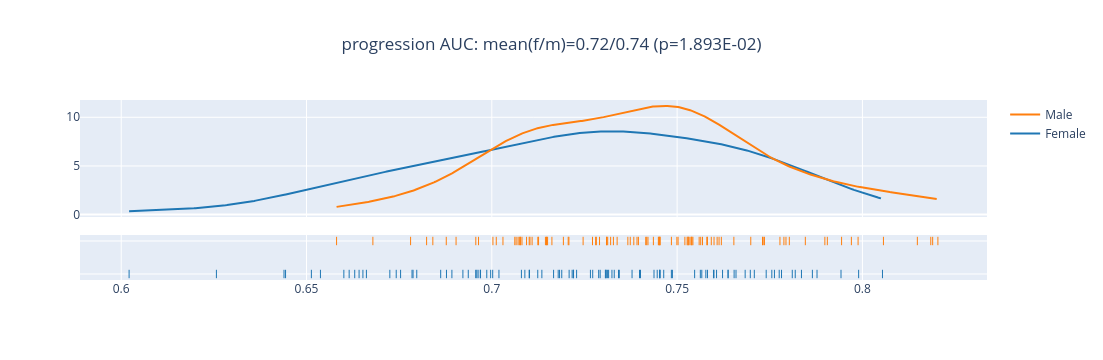

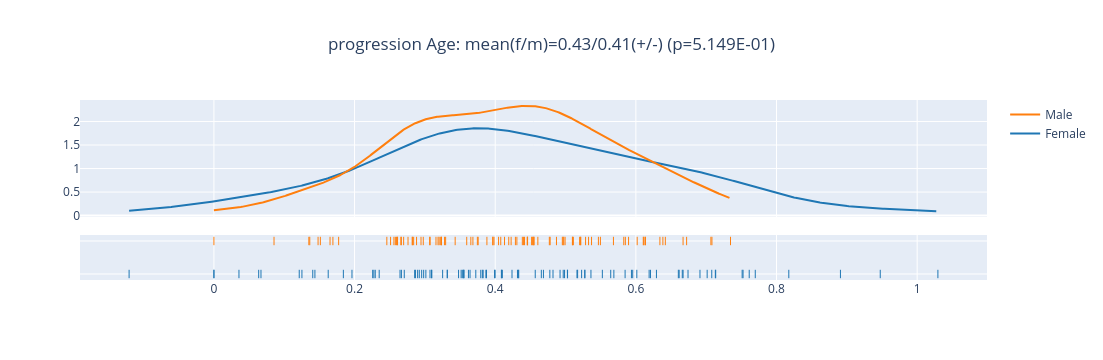

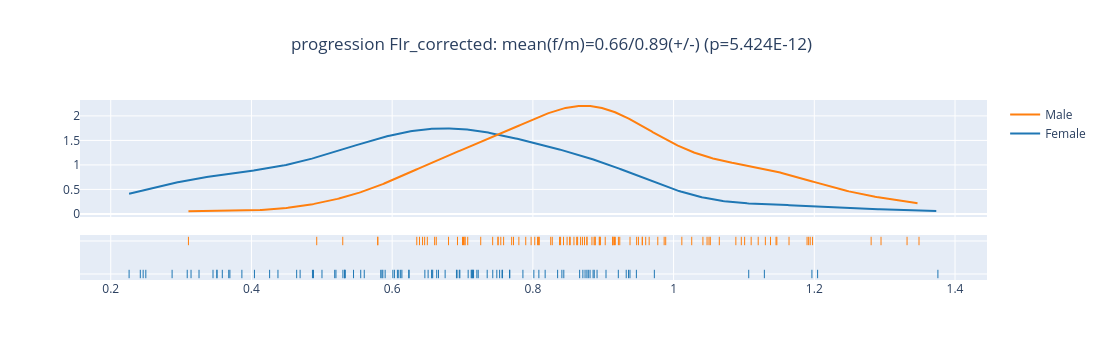

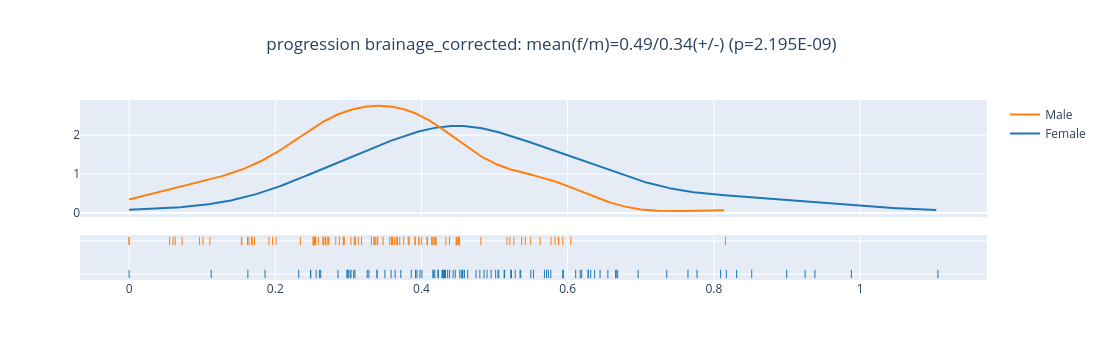

                              female              male             p
AUC                 0.72 (0.72-0.73)  0.74 (0.73-0.75)  1.893160e-02
Age                 0.43 (0.39-0.47)  0.41 (0.38-0.44)  5.149406e-01
FIr_corrected       0.66 (0.62-0.71)  0.89 (0.85-0.93)  5.423673e-12
brainage_corrected  0.49 (0.45-0.53)  0.34 (0.31-0.37)  2.195407e-09


In [73]:
import scipy.stats as st

from collections import Counter
from scipy.stats import mannwhitneyu, sem, ttest_ind, wilcoxon
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


np.random.seed(42)

NUM_REPEATS = 100

covariates = {
    #'CN/AD': ['Age', 'FIr_corrected', 'dunedin_pace_corrected'],
    #'CN/MCI': ['Age', 'FIr_corrected', 'brainage_corrected'], 
    #'MCI/AD': ['Age', 'FIr_corrected', 'brainage_corrected'], 
    'progression': ['Age', 'FIr_corrected', 'brainage_corrected'],
    #'progression': ['Age', 'FIr_corrected', 'brainage_corrected', 'RAVLT_immediate', 'TRABSCOR', 'APOE4']
}

sex_df = pd.concat([stage_one, stage_two, test])

for target, predictors in covariates.items():
    cv_aucs = {'female': [], 'male': []}
    coefs = {'female': [], 'male': []}
    
    subset = sex_df[[target, 'Sex'] + predictors]
    subset = subset.dropna()
    subset['idx'] = np.arange(len(subset))
    
    for _ in tqdm(range(NUM_REPEATS)):
        inner_train = subset.sample(int(len(subset) * 0.8), replace=True)
        #inner_train = inner_train.sort_values([target, 'Sex', 'Age'])
        #inner_train['fold'] = np.arange(len(inner_train)) % NUM_FOLDS
        #splitter = PredefinedSplit(inner_train['fold'])
        
        inner_test = subset[~subset['idx'].isin(inner_train['idx'])]

        #model = LogisticRegressionCV(scoring='roc_auc', random_state=42, cv=splitter,
        #                         penalty='l1', solver='liblinear', n_jobs=8)

        #pipeline = make_pipeline(
        #    StandardScaler(),
        #    SimpleImputer(),
        #    model
        #)
        #pipeline.fit(inner_train[predictors], inner_train[target])
        #predictions = pipeline.predict_proba(inner_test[predictors])[:,1]
        #auc = roc_auc_score(inner_test[target], predictions)
        #cv_aucs['combined'].append(auc)
        #coefs['combined'].append(model.coef_.squeeze())
    
        for sex, label in [('female', 0), ('male', 1)]:
            sex_train = inner_train[inner_train['Sex'] == label]
            
            if len(sex_train[sex_train[target] == 1]) <= NUM_FOLDS:
                continue
                
            sex_train = sex_train.sort_values([target, 'Age'])
            sex_train['fold'] = np.arange(len(sex_train)) % NUM_FOLDS
            splitter = PredefinedSplit(sex_train['fold'])
            
            sex_test = inner_test[inner_test['Sex'] == label]
            
            if len(sex_train[target].unique()) == 1 or len(sex_test[target].unique()) == 1:
                continue
            
            sex_model = LogisticRegressionCV(scoring='roc_auc', random_state=42, cv=splitter,
                                             penalty='l1', solver='liblinear', n_jobs=8)

            sex_pipeline = make_pipeline(
                StandardScaler(),
                SimpleImputer(),
                sex_model
            )
            sex_pipeline.fit(sex_train[predictors], sex_train[target])
            sex_predictions = sex_pipeline.predict_proba(sex_test[predictors])[:,1]
            sex_auc = roc_auc_score(sex_test[target], sex_predictions)
            cv_aucs[sex].append(sex_auc)
            coefs[sex].append(sex_model.coef_.squeeze())

    print(target)
    for key in cv_aucs:
        print(f'{key}: {np.round(np.mean(cv_aucs[key]), 2)}+/-{np.round(np.std(cv_aucs[key]), 2)}')
    
    for key in coefs:
        coefs[key] = np.asarray(coefs[key])
    
    female_mean = np.mean(cv_aucs['female'])
    male_mean = np.mean(cv_aucs['male'])
    auc_p = mannwhitneyu(cv_aucs['female'], cv_aucs['male'])[1]
    auc_plot = create_distplot([cv_aucs['female'], cv_aucs['male']], ['Female', 'Male'], show_hist=False)
    auc_plot.update_layout(title={
        'x': 0.5,
        'text': f'{target} AUC: mean(f/m)={female_mean:.2f}/{male_mean:.2f} (p={auc_p:.3E})'
    })
    auc_plot.show()
    
    coef_overviews = {
        'female': {},
        'male': {}
    }
    
    coef_ps = {}
            
    for i, covariate in enumerate(covariates[target]):
        if len(np.unique(coefs['female'][:,i])) == 1 or len(np.unique(coefs['male'][:,i])) == 1:
            continue
        
        coef_p = mannwhitneyu(coefs['female'][:,i], coefs['male'][:,i])[1]  
        coef_plot = create_distplot([coefs['female'][:,i], coefs['male'][:,i]], ['Female', 'Male'], show_hist=False)

        means = {sex: np.mean(coefs[sex][:,i]) for sex in ['female', 'male']}
        intervals = {sex: st.t.interval(confidence=0.95, df=NUM_REPEATS-1, 
                                   loc=means[sex], scale=sem(coefs[sex][:,i])) \
                     for sex in means}
        
        title = f'{target} {covariate}: mean(f/m)={means["female"]:.2f}/{means["male"]:.2f}(+/-) (p={coef_p:.3E})'
        coef_plot.update_layout(title={
            'x': 0.5,
            'text': title
        })
        coef_plot.show()
        
        for sex in means:
            coef_overviews[sex][covariate] = {'mean': means[sex], 'std': sem(coefs[sex][:,i]), 
                                              'lower': intervals[sex][0], 'upper': intervals[sex][1]}
        coef_ps[covariate] = coef_p
    auc_intervals = {sex: st.t.interval(confidence=0.95, df=NUM_REPEATS-1, 
                                        loc=np.mean(cv_aucs[sex]), scale=sem(cv_aucs[sex])) \
                     for sex in cv_aucs}
    
    covariates = list(coef_overviews['female'].keys())
    data = {sex: [(f'{coef_overviews[sex][covariate]["mean"]:.2f} '
                   f'({coef_overviews[sex][covariate]["lower"]:.2f}-'
                   f'{coef_overviews[sex][covariate]["upper"]:.2f})') \
                  for covariate in covariates] \
            for sex in ['female', 'male']}
    coef_overviews = pd.DataFrame(data, index=covariates)
    overviews = pd.concat([
        pd.DataFrame({sex: [f'{np.mean(cv_aucs[sex]):.2f} '
                            f'({auc_intervals[sex][0]:.2f}-{auc_intervals[sex][1]:.2f})'] \
                      for sex in ['female', 'male']}, index=['AUC']),
        coef_overviews
    ])
    overviews['p'] = [auc_p] + [coef_ps[key] for key in overviews.index[1:]]
    print(overviews)
    """
    #print(target)
    #print(f'Mean CV AUC: {np.round(np.mean(cv_aucs['combined']), 2)}')
    #print(f'Mean {sex} CV AUC: {np.round(np.mean(sex_cv_aucs), 2)}+/-{np.round(np.std(sex_cv_aucs), 2)}')

    

    for sex, label in [('female', 0), ('male', 1)]:
        sex_idx = subset['Sex'] == label
        sex_subset = subset[sex_idx]

        sex_pipeline.fit(sex_subset[predictors], sex_subset[target])
        sex_predictions = sex_pipeline.predict(test.loc[sex_idx, predictors])
        test_sex_idx = test_subset[test_subset['Sex'] == label]
        test_subset.loc[test_sex_idx, f'{target}_predictions_{label}'] = sex_predictions
        sex_auc = roc_auc_score(test.loc[test_sex_idx, target], sex_predictions)
        print(f'{sex} AUC: {sex_auc}')
    """